# XGC f-data

* [XGC cooridanation system](https://www.google.com/url?sa=i&url=https%3A%2F%2Fxgc.pppl.gov%2Fhtml%2Fmeshing_tutorial.html&psig=AOvVaw2QaOB5NbF6-XReGUykRkCw&ust=1645642237081000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCOjRgZz9k_YCFQAAAAAdAAAAABAD)
* [XGC domains](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.exascaleproject.org%2Flets-talk-exascale-code-development-wdmapp-xgc-gene-gem%2F&psig=AOvVaw2QaOB5NbF6-XReGUykRkCw&ust=1645642237081000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCOjRgZz9k_YCFQAAAAAdAAAAABAJ)

In [ ]:
%%shell
## Download adios2 deb
time wget --no-check-cert -O adios2_2.7.0_amd64.deb https://www.dropbox.com/s/7r110glbh3lm243/adios2_2.7.0_amd64.deb?dl=0

## Install adios2 deb
dpkg -i ./adios2_2.7.0_amd64.deb
apt-get install -f

--2022-03-03 19:07:12--  https://www.dropbox.com/s/7r110glbh3lm243/adios2_2.7.0_amd64.deb?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7r110glbh3lm243/adios2_2.7.0_amd64.deb [following]
--2022-03-03 19:07:12--  https://www.dropbox.com/s/raw/7r110glbh3lm243/adios2_2.7.0_amd64.deb
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc79bd53ecead517f97734ae9661.dl.dropboxusercontent.com/cd/0/inline/BgwZZABhMHhUldbfXqCz-BkFuYVcOZVocwRIWdbz_vwmhsYAijQfZNesJBPw5XCwHGqZg37k9Qf6W3OpOwp-KdDcMaxulcj9uB5me5bFps5YYLdHJA5KUOOGqMzGriqZ3IODA8QsCt72-bGsqtGn7lPb/file# [following]
--2022-03-03 19:07:13--  https://uc79bd53ecead517f97734ae9661.dl.dropboxusercontent.com/cd/0/inline/BgwZZABhMHhUldbfXqCz-BkFuYVcOZVocwRIWdbz_vwmhsYAijQfZNe

In [ ]:
%%shell
time wget --no-check-cert https://www.dropbox.com/s/lmvgj6ulcgb5stu/d3d_coarse_v2_colab.tar.gz
time tar xvzf d3d_coarse_v2_colab.tar.gz

--2022-03-03 19:07:28--  https://www.dropbox.com/s/lmvgj6ulcgb5stu/d3d_coarse_v2_colab.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lmvgj6ulcgb5stu/d3d_coarse_v2_colab.tar.gz [following]
--2022-03-03 19:07:29--  https://www.dropbox.com/s/raw/lmvgj6ulcgb5stu/d3d_coarse_v2_colab.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc99e4b665ae2378686bfe49216c.dl.dropboxusercontent.com/cd/0/inline/BgxYXC4S8w7UD3BGPwub9sNxAXnNuuErB1AuxCr6NMHeHj8d8xJ0AFgzoKgecGJzkLvErezH4C6W0gqQWFVNKLRYQ3rVYV38oScMUynAh_rRYwdTJ1hKI_zPLy37jXKM2LEqxFgMy5agrv9VEaHwpFxr/file# [following]
--2022-03-03 19:07:29--  https://uc99e4b665ae2378686bfe49216c.dl.dropboxusercontent.com/cd/0/inline/BgxYXC4S8w7UD3BGPwub9sNxAXnNuuErB1AuxCr6NMHeHj8d

In [ ]:
%%shell
ls d3d_coarse_v2_colab

fort.input.used  xgc.equil.bp		   xgc.fluxavg.bp  xgc.units.bp
restart_dir	 xgc.f0analysis.static.bp  xgc.grad_rz.bp
xgc.bfield.bp	 xgc.f0.mesh.bp		   xgc.mesh.bp


In [ ]:
import numpy as np
import adios2 as ad2
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import os
import logging

In [ ]:
def read_f0(istep, expdir=None, iphi=None, inode=0, nnodes=None, average=False, randomread=0.0, nchunk=16, fieldline=False):
    """
    Read XGC f0 data
    """
    def adios2_get_shape(f, varname):
        nstep = int(f.available_variables()[varname]['AvailableStepsCount'])
        shape = f.available_variables()[varname]['Shape']
        lshape = None
        if shape == '':
            ## Accessing Adios1 file
            ## Read data and figure out
            v = f.read(varname)
            lshape = v.shape
        else:
            lshape = tuple([ int(x.strip(',')) for x in shape.strip().split() ])
        return (nstep, lshape)

    fname = os.path.join(expdir, 'restart_dir/xgc.f0.%05d.bp'%istep)
    if randomread > 0.0:
        ## prefetch to get metadata
        with ad2.open(fname, 'r') as f:
            nstep, nsize = adios2_get_shape(f, 'i_f')
            ndim = len(nsize)
            nphi = nsize[0]
            _nnodes = nsize[2] if nnodes is None else nnodes
            nmu = nsize[1]
            nvp = nsize[3]
        assert _nnodes%nchunk == 0
        _lnodes = list(range(inode, inode+_nnodes, nchunk))
        lnodes = random.sample(_lnodes, k=int(len(_lnodes)*randomread))
        lnodes = np.sort(lnodes)

        lf = list()
        li = list()
        for i in tqdm(lnodes):
            li.append(np.array(range(i,i+nchunk), dtype=np.int32))
            with ad2.open(fname, 'r') as f:
                nphi = nsize[0] if iphi is None else 1
                iphi = 0 if iphi is None else iphi
                start = (iphi,0,i,0)
                count = (nphi,nmu,nchunk,nvp)
                _f = f.read('i_f', start=start, count=count).astype('float64')
                lf.append(_f)
        i_f = np.concatenate(lf, axis=2)
        lb = np.concatenate(li)
    elif fieldline is True:
        import networkx as nx

        fname2 = os.path.join(expdir, 'xgc.mesh.bp')
        with ad2.open(fname2, 'r') as f:
            _nnodes = int(f.read('n_n', ))
            nextnode = f.read('nextnode')
        
        G = nx.Graph()
        for i in range(_nnodes):
            G.add_node(i)
        for i in range(_nnodes):
            G.add_edge(i, nextnode[i])
            G.add_edge(nextnode[i], i)
        cc = [x for x in list(nx.connected_components(G)) if len(x) >= 16]

        li = list()
        for k, components in enumerate(cc):
            DG = nx.DiGraph()
            for i in components:
                DG.add_node(i)
            for i in components:
                DG.add_edge(i, nextnode[i])
            
            cycle = list(nx.find_cycle(DG))
            DG.remove_edge(*cycle[-1])
            
            path = nx.dag_longest_path(DG)
            #print (k, len(components), path[0])
            for i in path[:len(path)-len(path)%16]:
                li.append(i)

        with ad2.open(fname, 'r') as f:
            nstep, nsize = adios2_get_shape(f, 'i_f')
            ndim = len(nsize)
            nphi = nsize[0] if iphi is None else 1
            iphi = 0 if iphi is None else iphi
            _nnodes = nsize[2]
            nmu = nsize[1]
            nvp = nsize[3]
            start = (iphi,0,0,0)
            count = (nphi,nmu,_nnodes,nvp)
            logging.info (f"Reading: {start} {count}")
            i_f = f.read('i_f', start=start, count=count).astype('float64')
        
        _nnodes = len(li)-inode if nnodes is None else nnodes
        lb = np.array(li[inode:inode+_nnodes], dtype=np.int32)
        logging.info (f"Fieldline: {len(lb)}")
        logging.info (f"{lb}")
        i_f = i_f[:,:,lb,:]
    else:
        with ad2.open(fname, 'r') as f:
            nstep, nsize = adios2_get_shape(f, 'i_f')
            ndim = len(nsize)
            nphi = nsize[0] if iphi is None else 1
            iphi = 0 if iphi is None else iphi
            _nnodes = nsize[2]-inode if nnodes is None else nnodes
            nmu = nsize[1]
            nvp = nsize[3]
            start = (iphi,0,inode,0)
            count = (nphi,nmu,_nnodes,nvp)
            logging.info (f"Reading: {start} {count}")
            i_f = f.read('i_f', start=start, count=count).astype('float64')
            #e_f = f.read('e_f')
        li = list(range(inode, inode+_nnodes))
        lb = np.array(li, dtype=np.int32)

    # if i_f.shape[3] == 31:
    #     i_f = np.append(i_f, i_f[...,30:31], axis=3)
    #     # e_f = np.append(e_f, e_f[...,30:31], axis=3)
    # if i_f.shape[3] == 39:
    #     i_f = np.append(i_f, i_f[...,38:39], axis=3)
    #     i_f = np.append(i_f, i_f[:,38:39,:,:], axis=1)

    Z0 = np.moveaxis(i_f, 1, 2)

    if average:
        Z0 = np.mean(Z0, axis=0)
        zlb = lb
    else:
        Z0 = Z0.reshape((-1,Z0.shape[2],Z0.shape[3]))
        _lb = list()
        for i in range(nphi):
            _lb.append( i*100_000_000 + lb)
        zlb = np.concatenate(_lb)
    
    #zlb = np.concatenate(li)
    zmu = np.mean(Z0, axis=(1,2))
    zsig = np.std(Z0, axis=(1,2))
    zmin = np.min(Z0, axis=(1,2))
    zmax = np.max(Z0, axis=(1,2))
    Zif = (Z0 - zmin[:,np.newaxis,np.newaxis])/(zmax-zmin)[:,np.newaxis,np.newaxis]

    return (Z0, Zif, zmu, zsig, zmin, zmax, zlb)

In [ ]:
with ad2.open('d3d_coarse_v2_colab/xgc.mesh.bp', 'r') as f:
    nnodes = int(f.read('n_n', ))
    ncells = int(f.read('n_t', ))
    rz = f.read('rz')
    conn = f.read('nd_connect_list')
    psi = f.read('psi')
    nextnode = f.read('nextnode')
    epsilon = f.read('epsilon')
    node_vol = f.read('node_vol')
    node_vol_nearest = f.read('node_vol_nearest')
r = rz[:,0]
z = rz[:,1]
print(rz.shape)
print (nnodes,ncells)
#print(conn)
print(node_vol.shape,psi.shape)

(16395, 2)
16395 32524
(16395,) (16395,)


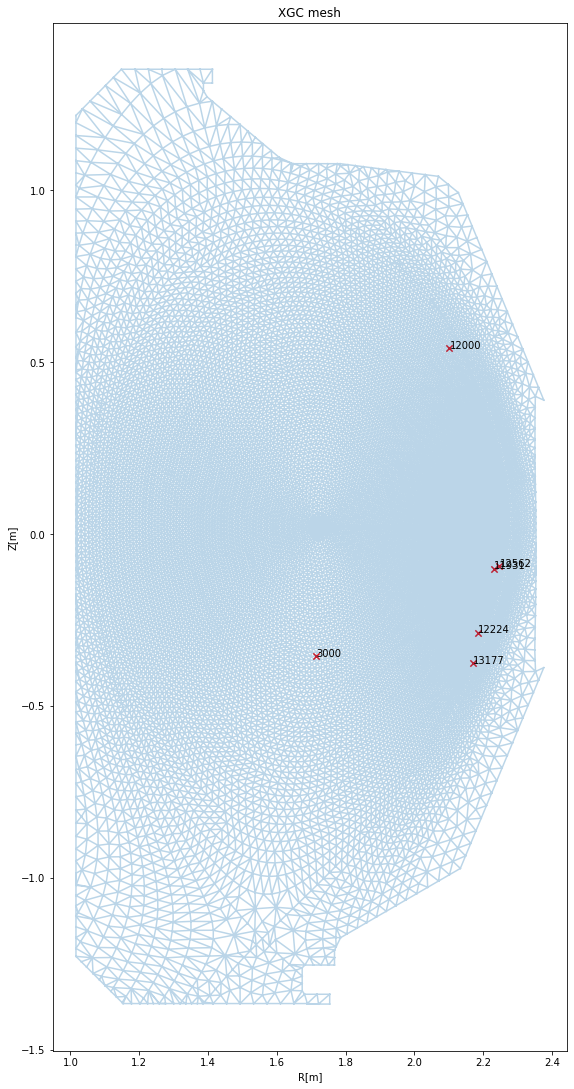

In [ ]:
plt.figure(figsize=[8,16])

trimesh = tri.Triangulation(r, z, conn)
plt.triplot(trimesh, alpha=0.3)
plt.xlabel('R[m]')
plt.ylabel('Z[m]')
plt.title('XGC mesh')
plt.axis('scaled')
plt.tight_layout()
for i in [3000,12000,11931,12224,12562,13177,]:
  plt.scatter(r[i], z[i], c='r', marker='x', s=40)
  plt.text(r[i], z[i], i)

In [ ]:
%%shell
bpls -lva d3d_coarse_v2_colab/restart_dir/xgc.f0.00420.bp #420 time-steps

File info:
  of variables:  1
  of attributes: 0
  statistics:    Min / Max 

  float    i_f   {8, 39, 16395, 39} = 658832 / 5.95128e+17


In [ ]:
Z0, Zif, zmu, zsig, zmin, zmax, zlb = read_f0(420, expdir='d3d_coarse_v2_colab', iphi=0)
print(Zif.shape)
print(zlb.shape) #node index

(16395, 39, 39)
(16395,)


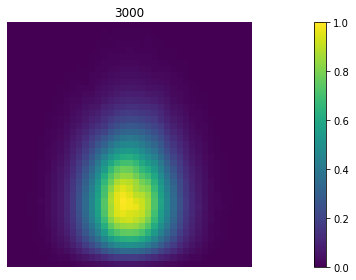

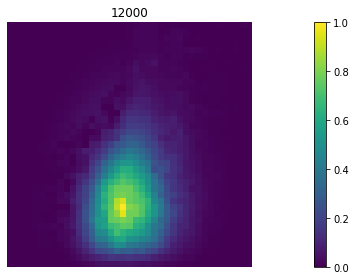

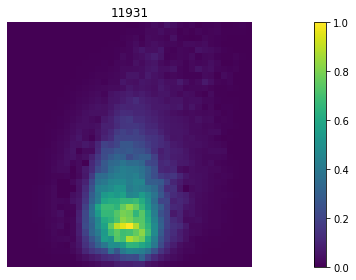

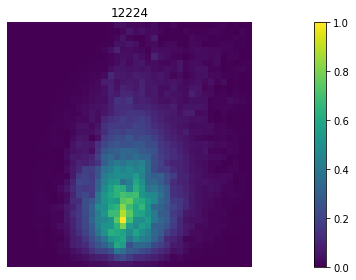

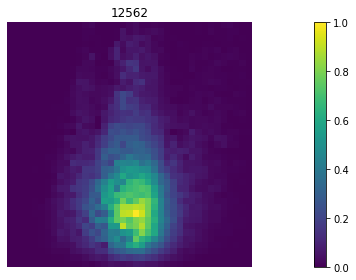

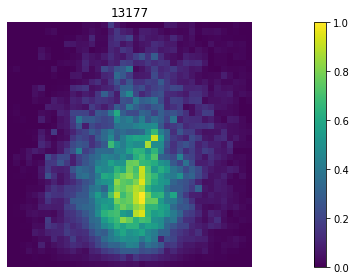

In [ ]:
_, ny, nx = Zif.shape
ix = np.linspace(0, nx-1, nx)
iy = np.linspace(0, ny-1, ny)
Mx, My = np.meshgrid(ix, iy)

for i in [3000,12000,11931,12224,12562,13177,]:
    X = Zif[i,:,:]

    plt.figure()
    plt.imshow(X, origin='lower')
    plt.colorbar()
    # plt.contour(Mx, My, X, levels=5, origin='image', colors='white', alpha=0.5)
    plt.axis('scaled')
    plt.axis('off')
    plt.title('%d'%(i))
    plt.tight_layout()
